In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium

In [144]:
#sem usar utf-8, "vítimas" ficava como "vÃtimas"
df_2021 = pd.read_csv('2021.csv', encoding='latin-1', sep=';')
df_2022 = pd.read_csv('2022.csv', encoding='utf-8', sep=',')
df_2023 = pd.read_csv('2023.csv', encoding='latin-1', sep=';')
df_2024 = pd.read_csv('2024.csv', encoding='utf-8', sep=',')

In [145]:
#conferindo se têm o mesmo número de colunas
print(df_2021.shape)
print(df_2022.shape)
print(df_2023.shape)
print(df_2024.shape)

(64567, 30)
(64606, 30)
(67766, 30)
(53950, 30)


In [146]:
#conferindo se as colunas são tadas as mesmas
print(df_2021.columns == df_2022.columns)
print(df_2023.columns == df_2024.columns)
print(df_2022.columns == df_2023.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


In [147]:
#concatenando os dfs
df_concat = pd.concat([df_2021, df_2022, df_2023, df_2024], ignore_index=True)
df_concat.shape

(250889, 30)

In [148]:
df_concat.to_csv('2021-22-23-24.csv', index=False)

In [149]:
df = pd.read_csv('2021-22-23-24.csv')

In [150]:
df.isnull().sum()

id                          0
data_inversa                0
dia_semana                  0
horario                     0
uf                          0
br                          0
km                          0
municipio                   0
causa_acidente              0
tipo_acidente               0
classificacao_acidente      4
fase_dia                    0
sentido_via                 0
condicao_metereologica      0
tipo_pista                  0
tracado_via                 0
uso_solo                    0
pessoas                     0
mortos                      0
feridos_leves               0
feridos_graves              0
ilesos                      0
ignorados                   0
feridos                     0
veiculos                    0
latitude                    0
longitude                   0
regional                   23
delegacia                  85
uop                       219
dtype: int64

-> Em 4 casos não sabemos a classificação do acidente. Vamos preencher com a moda para cada tipo de acidente.

In [152]:
df[df['classificacao_acidente'].isna()]

id data_inversa     dia_semana   horario  uf   br    km  \
1       331804.0   2021-01-01    sexta-feira  08:05:00  AM  174   937   
64567   405151.0   2022-01-01         sábado  01:35:00  PI  316   415   
129175  496590.0   2023-01-01        domingo  01:40:00  MT  163  1112   
196939  571789.0   2024-01-01  segunda-feira  03:56:00  ES  101    38   

                 municipio                            causa_acidente  \
1                   MANAUS  Reação tardia ou ineficiente do condutor   
64567          MARCOLANDIA          Ingestão de álcool pelo condutor   
129175   GUARANTA DO NORTE  Reação tardia ou ineficiente do condutor   
196939  CONCEICAO DA BARRA                    Ultrapassagem Indevida   

                         tipo_acidente  ... feridos_graves ilesos ignorados  \
1                     Colisão traseira  ...              0      5         1   
64567                 Colisão traseira  ...              0      1         1   
129175                      Tombamento  ...              1      0         2   
196939  Colisão lateral sentido oposto  ...              1      1         1   

       feridos veiculos     latitude     longitude  regional  delegacia  \
1            1        5    -2,508068    -60,036434   SPRF-AM   DEL01-AM   
64567        1        3  -7,43280012  -40,68261908   SPRF-PI   DEL04-PI   
129175       1        3  -9,70020602  -54,87588757   SPRF-MT   DEL06-MT   
196939       1        3    -18,48261     -39,92379   SPRF-ES   DEL04-ES   

                   uop  
1       UOP01-DEL01-AM  
64567   UOP03-DEL04-PI  
129175  UOP03-DEL06-MT  
196939  UOP02-DEL04-ES  

[4 rows x 30 columns]

In [153]:
#preenchendo classificacao do acidente

for _, row in df[df['classificacao_acidente'].isna()].iterrows(): #iterrows retorna uma tupla com um int e uma serie
    # print(type(_))
    # print(type(row))
    df.loc[df['id'] == row['id'], 'classificacao_acidente'] = df[ #localiza a classificacao do acidente faltante pelo id
        (df['tipo_acidente'] == row['tipo_acidente']) & #entre as linhas com mesmo tipo de acidente
        (df['causa_acidente'] == row['causa_acidente']) #e mesma causa do acidente
      ]['classificacao_acidente'].value_counts().idxmax() #pega a moda e preenche o valor que tava faltando
    # print('achou')

In [154]:
#preenchendo regional

for _, row in df[df['regional'].isna()].iterrows(): #iterrows retorna uma tupla com um int e uma serie
    # print(type(_))
    # print(type(row))
    df.loc[df['id'] == row['id'], 'regional'] = 'SPRF-' + row['uf'] #SRPF + o estado
    # print('achou')

In [157]:
#preenchendo delegacia

for _, row in df[df['delegacia'].isna()].iterrows(): #iterrows retorna uma tupla com um int e uma serie

    df_uf = df[(df['uf'] == row['uf']) & (df['delegacia'].notna())].copy() #pega todos com mesmo UF, exceto os que não tiverem delegacia
    latitude = float(row['latitude'].replace(',', '.'))
    longitude = float(row['longitude'].replace(',', '.'))

    df_uf['latitude'] = df_uf['latitude'].str.replace(',', '.', regex=False).astype(float)
    df_uf['longitude'] = df_uf['longitude'].str.replace(',', '.', regex=False).astype(float)
   
    df_uf['distancia'] = ((df_uf['latitude']-latitude)**2 + (df_uf['longitude']-longitude)**2)**(1/2)
    
    df.loc[df['id'] == row['id'], 'delegacia'] = df_uf.loc[df_uf['distancia'].idxmin(), 'delegacia']
    # print('achou')




In [160]:
#preenchendo uop - Unidade Operacional da PRF
for _, row in df[df['uop'].isna()].iterrows(): #iterrows retorna uma tupla com um int e uma serie

    df_uf = df[(df['uf'] == row['uf']) & (df['uop'].notna())].copy() #pega todos com mesmo UF, exceto os que não tiverem uop
    latitude = float(row['latitude'].replace(',', '.'))
    longitude = float(row['longitude'].replace(',', '.'))

    df_uf['latitude'] = df_uf['latitude'].str.replace(',', '.', regex=False).astype(float)
    df_uf['longitude'] = df_uf['longitude'].str.replace(',', '.', regex=False).astype(float)
   
    df_uf['distancia'] = ((df_uf['latitude']-latitude)**2 + (df_uf['longitude']-longitude)**2)**(1/2)
    
    df.loc[df['id'] == row['id'], 'uop'] = df_uf.loc[df_uf['distancia'].idxmin(), 'uop']
    # print('achou')

In [161]:
df['data_inversa'] = pd.to_datetime(df['data_inversa'], dayfirst=False, errors='coerce')

In [162]:
df['horario'] = pd.to_datetime(df['horario'], format='%H:%M:%S', errors='coerce').dt.time

In [163]:
df['hora'] = pd.to_datetime(df['horario'], format='%H:%M:%S', errors='coerce').dt.hour

In [164]:
# print(len(df))
# df = df.drop_duplicates()
# print(len(df))

In [165]:
duplicatas = df[df.duplicated()]
print(f'Número de duplicadas: {len(duplicatas)}')


Número de duplicadas: 0


In [166]:
df.columns

Index(['id', 'data_inversa', 'dia_semana', 'horario', 'uf', 'br', 'km',
       'municipio', 'causa_acidente', 'tipo_acidente',
       'classificacao_acidente', 'fase_dia', 'sentido_via',
       'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo',
       'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos',
       'ignorados', 'feridos', 'veiculos', 'latitude', 'longitude', 'regional',
       'delegacia', 'uop', 'hora'],
      dtype='object')

In [167]:
#vítimas  = mortos + feridos
df['total_vitimas']	= df['mortos'] + df['feridos']

In [168]:
df['ano'] = df['data_inversa'].dt.year
df['mes'] = df['data_inversa'].dt.month
df['dia_do_mes'] = df['data_inversa'].dt.day

In [169]:
df.columns

Index(['id', 'data_inversa', 'dia_semana', 'horario', 'uf', 'br', 'km',
       'municipio', 'causa_acidente', 'tipo_acidente',
       'classificacao_acidente', 'fase_dia', 'sentido_via',
       'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo',
       'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos',
       'ignorados', 'feridos', 'veiculos', 'latitude', 'longitude', 'regional',
       'delegacia', 'uop', 'hora', 'total_vitimas', 'ano', 'mes',
       'dia_do_mes'],
      dtype='object')

In [170]:
(df['feridos'] == df['feridos_leves'] + df['feridos_graves']).sum()

np.int64(250889)

In [171]:
if len(df.loc[df['veiculos'] == 0]) == 0:
    df['feridos_por_veiculo'] = df['feridos'] / df['veiculos']


In [172]:
df.columns

Index(['id', 'data_inversa', 'dia_semana', 'horario', 'uf', 'br', 'km',
       'municipio', 'causa_acidente', 'tipo_acidente',
       'classificacao_acidente', 'fase_dia', 'sentido_via',
       'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo',
       'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos',
       'ignorados', 'feridos', 'veiculos', 'latitude', 'longitude', 'regional',
       'delegacia', 'uop', 'hora', 'total_vitimas', 'ano', 'mes', 'dia_do_mes',
       'feridos_por_veiculo'],
      dtype='object')

In [195]:
df.to_csv('2021-22-23-24.csv', index=False)

#start

In [ ]:
df = pd.read_csv('2021-22-23-24.csv')

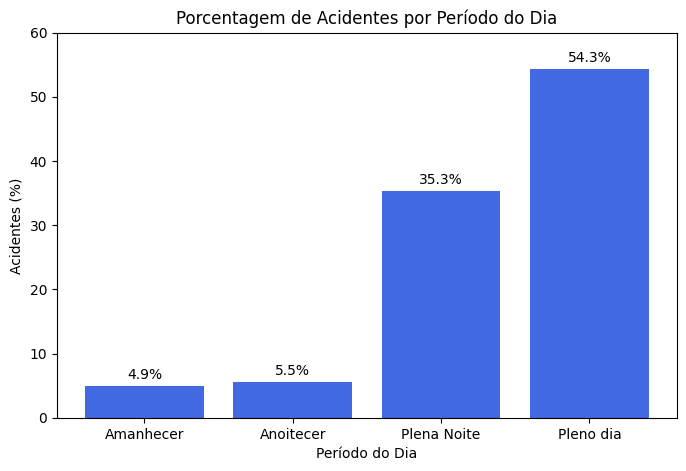

In [42]:
#contagem de acidentes por período do dia (%)
contagem = df['fase_dia'].value_counts(normalize=True).sort_index() * 100

fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(contagem.index, contagem.values, color='royalblue') #/contagem.sum() para %

valor_max = np.ceil(contagem.max()*1.1/5)*5 #arrendonda para cima para o próximo múltiplo de 5. O 1.1 é pra dar um respiro no gráfico.
ax.set_ylim(0, valor_max)

ticks = np.arange(0, valor_max+1, 10)
ax.set_yticks(ticks)

ax.bar_label(bars, fmt='%.1f%%', padding=3)

ax.set_title('Porcentagem de Acidentes por Período do Dia')
ax.set_xlabel('Período do Dia')
ax.set_ylabel('Acidentes (%)')

plt.show()

In [44]:
contagem_por_ano = df.groupby(['ano', 'fase_dia']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum())

In [46]:
contagem_por_ano

ano   ano   fase_dia   
2021  2021  Amanhecer       4.644788
            Anoitecer       5.662335
            Plena Noite    35.796924
            Pleno dia      53.895953
2022  2022  Amanhecer       5.188373
            Anoitecer       5.480915
            Plena Noite    35.403832
            Pleno dia      53.926880
2023  2023  Amanhecer       4.919871
            Anoitecer       5.480625
            Plena Noite    34.523212
            Pleno dia      55.076292
2024  2024  Amanhecer       4.839666
            Anoitecer       5.558851
            Plena Noite    35.360519
            Pleno dia      54.240964
dtype: float64

In [48]:
contagem_por_ano = df.groupby(['ano', 'fase_dia']).size()
# contagem_por_ano = contagem_por_ano.groupby('ano').apply(lambda x: 100 * x / x.sum())

In [50]:
contagem_por_ano

ano   fase_dia   
2021  Amanhecer       2999
      Anoitecer       3656
      Plena Noite    23113
      Pleno dia      34799
2022  Amanhecer       3352
      Anoitecer       3541
      Plena Noite    22873
      Pleno dia      34840
2023  Amanhecer       3334
      Anoitecer       3714
      Plena Noite    23395
      Pleno dia      37323
2024  Amanhecer       2611
      Anoitecer       2999
      Plena Noite    19077
      Pleno dia      29263
dtype: int64

In [52]:
df_contagem = contagem_por_ano.reset_index(name='Percentual')
df_contagem['Percentual'] = df_contagem.groupby('ano')['Percentual'].transform(lambda x: 100 * x / x.sum())
df_contagem

ano     fase_dia  Percentual
0   2021    Amanhecer    4.644788
1   2021    Anoitecer    5.662335
2   2021  Plena Noite   35.796924
3   2021    Pleno dia   53.895953
4   2022    Amanhecer    5.188373
5   2022    Anoitecer    5.480915
6   2022  Plena Noite   35.403832
7   2022    Pleno dia   53.926880
8   2023    Amanhecer    4.919871
9   2023    Anoitecer    5.480625
10  2023  Plena Noite   34.523212
11  2023    Pleno dia   55.076292
12  2024    Amanhecer    4.839666
13  2024    Anoitecer    5.558851
14  2024  Plena Noite   35.360519
15  2024    Pleno dia   54.240964

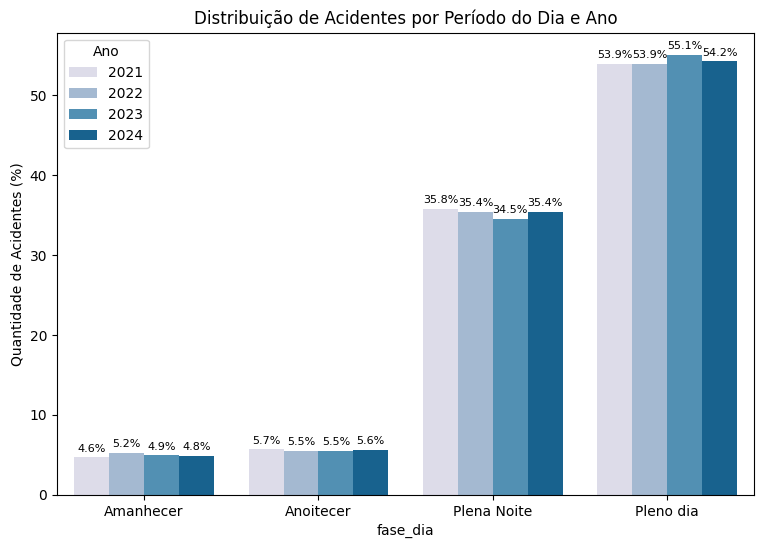

In [54]:
plt.figure(figsize=(9,6))


ax = sns.barplot(data=df_contagem, x='fase_dia', y='Percentual', hue='ano', palette=sns.color_palette("PuBu", 4))

for p in ax.patches:
    if p.get_height() != 0:
        altura = p.get_height()
        # print(altura)
        ax.text(p.get_x() + p.get_width()/2,
                altura + 0.5,  
                f'{altura:.1f}%', 
                ha='center', va='bottom', fontsize=8)
    
plt.title('Distribuição de Acidentes por Período do Dia e Ano')
plt.ylabel('Quantidade de Acidentes (%)')

plt.legend(title='Ano')

plt.show()

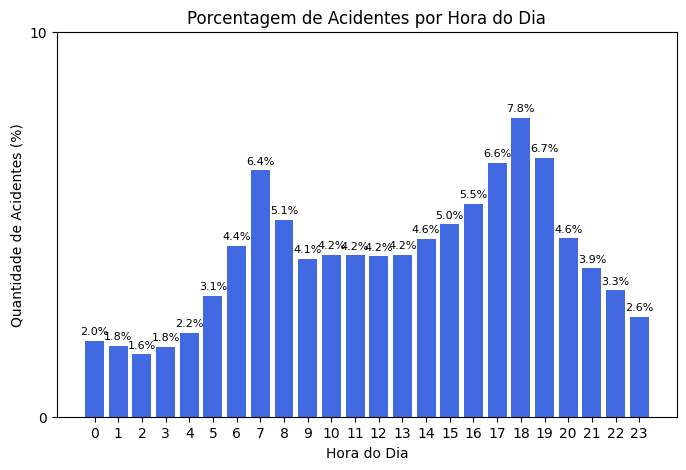

In [217]:
#contagem de acidentes por período do dia (%)
contagem = df[df['ano'].isin([2024])]['hora'].value_counts(normalize=True).sort_index() * 100

fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(contagem.index, contagem.values, color='royalblue') #/contagem.sum() para %

valor_max_y = np.ceil(contagem.max()*1.1/5)*5 #arrendonda para cima para o próximo múltiplo de 5. O 1.1 é pra dar um respiro no gráfico.
ax.set_ylim(0, valor_max_y)

yticks = np.arange(0, valor_max_y+1, 10)
ax.set_yticks(yticks)

valor_max_x = df['hora'].max()
xticks = np.arange(0, valor_max_x+1, 1)
ax.set_xticks(xticks)



labels = ax.bar_label(bars, fmt='%.1f%%', padding=3)
for label in labels:
    label.set_fontsize(8)


ax.set_title('Porcentagem de Acidentes por Hora do Dia')
ax.set_xlabel('Hora do Dia')
ax.set_ylabel('Quantidade de Acidentes (%)')

plt.show()

In [56]:
df.columns

Index(['id', 'data_inversa', 'dia_semana', 'horario', 'uf', 'br', 'km',
       'municipio', 'causa_acidente', 'tipo_acidente',
       'classificacao_acidente', 'fase_dia', 'sentido_via',
       'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo',
       'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos',
       'ignorados', 'feridos', 'veiculos', 'latitude', 'longitude', 'regional',
       'delegacia', 'uop', 'hora', 'total_vitimas', 'ano', 'mes', 'dia_do_mes',
       'feridos_por_veiculo'],
      dtype='object')

In [60]:
df['mes'].value_counts()

mes
7     23830
8     23005
9     22817
5     22814
6     22386
4     21632
1     21518
3     21482
2     19878
12    18299
10    17309
11    15919
Name: count, dtype: int64

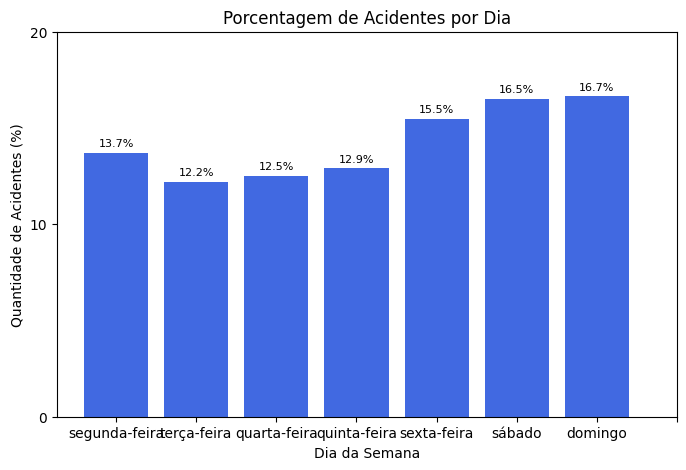

In [221]:
#contagem de acidentes por período do dia (%)
# contagem = df[df['mes'].isin([1])]['dia_semana'].value_counts(normalize=True).sort_index() * 100

#################################################################################################################

ordem_dias = ['segunda-feira', 'terça-feira', 'quarta-feira', 'quinta-feira', 
       'sexta-feira', 'sábado', 'domingo',]

contagem = df[df['mes'].isin([1,2,3,4,5,6,7,8,9,10,11,12])]['dia_semana'].value_counts(normalize=True) * 100

contagem.index = pd.Categorical(contagem.index, categories=ordem_dias, ordered=True)

contagem = contagem.sort_index()

##################################################################################################################

fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(contagem.index, contagem.values, color='royalblue') #/contagem.sum() para %

valor_max_y = np.ceil(contagem.max()*1.1/5)*5 #arrendonda para cima para o próximo múltiplo de 5. O 1.1 é pra dar um respiro no gráfico.
ax.set_ylim(0, valor_max_y)

yticks = np.arange(0, valor_max_y+1, 10)
ax.set_yticks(yticks)

valor_max_x = len(df['dia_semana'].unique())
xticks = np.arange(0, valor_max_x+1, 1)
ax.set_xticks(xticks)



labels = ax.bar_label(bars, fmt='%.1f%%', padding=3)
for label in labels:
    label.set_fontsize(8)


ax.set_title('Porcentagem de Acidentes por Dia')
ax.set_xlabel('Dia da Semana')
ax.set_ylabel('Quantidade de Acidentes (%)')

plt.show()

Vemos um aumento na quantidade de acidentes aos finais de semana.

C:\Users\diego\AppData\Local\Temp\ipykernel_412\4292523025.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(contagem.index, rotation=45)


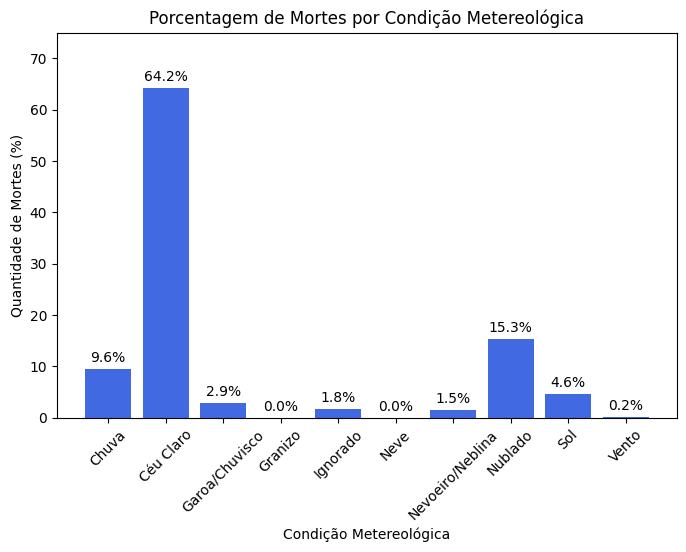

In [64]:
#contagem de acidentes por período do dia (%)
contagem = (df.groupby('condicao_metereologica')['mortos'].sum()*100)/df['mortos'].sum()
# contagem.sort_values(ascending=True)


fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(contagem.index, contagem.values, color='royalblue') #/contagem.sum() para %

valor_max = np.ceil(contagem.max()*1.1/5)*5 #arrendonda para cima para o próximo múltiplo de 5. O 1.1 é pra dar um respiro no gráfico.
ax.set_ylim(0, valor_max)

ticks = np.arange(0, valor_max+1, 10)
ax.set_yticks(ticks)

ax.bar_label(bars, fmt='%.1f%%', padding=3)

ax.set_title('Porcentagem de Mortes por Condição Metereológica')
ax.set_xlabel('Condição Metereológica')
ax.set_ylabel('Quantidade de Mortes (%)')

ax.set_xticklabels(contagem.index, rotation=45)

plt.show()

A grande maioria dos acidentes ocorrem com 'Céu Claro', talvez as boas condições meteorológicas tornem os motoristas menos atentos/mais propensos a altas velocidades, sendo mais perigoso que 'Chuva' e 'Nublado'.

In [66]:
(df.groupby('condicao_metereologica')['mortos'].sum()*100)/df['mortos'].sum()

condicao_metereologica
Chuva                9.570108
Céu Claro           64.188352
Garoa/Chuvisco       2.916786
Granizo              0.000000
Ignorado             1.763416
Neve                 0.000000
Nevoeiro/Neblina     1.467925
Nublado             15.289296
Sol                  4.642074
Vento                0.162044
Name: mortos, dtype: float64

C:\Users\diego\AppData\Local\Temp\ipykernel_412\943936885.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(contagem.index, rotation=90)


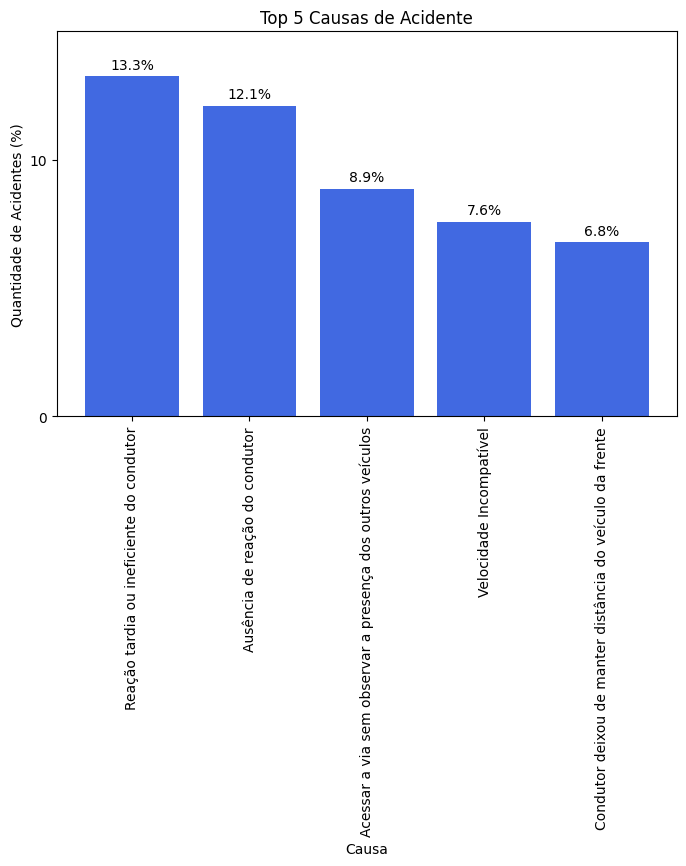

In [73]:
#contagem de acidentes por período do dia (%)
contagem = df['causa_acidente'].value_counts(normalize=True).sort_index() * 100
contagem = contagem.sort_values(ascending=False)[:5]
fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(contagem.index, contagem.values, color='royalblue') #/contagem.sum() para %

valor_max = np.ceil(contagem.max()*1.1/5)*5 #arrendonda para cima para o próximo múltiplo de 5. O 1.1 é pra dar um respiro no gráfico.
ax.set_ylim(0, valor_max)

ticks = np.arange(0, valor_max+1, 10)
ax.set_yticks(ticks)

ax.bar_label(bars, fmt='%.1f%%', padding=3)

ax.set_title('Top 5 Causas de Acidente')
ax.set_xlabel('Causa')
ax.set_ylabel('Quantidade de Acidentes (%)')

ax.set_xticklabels(contagem.index, rotation=90)


plt.show()

C:\Users\diego\AppData\Local\Temp\ipykernel_412\36158753.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(contagem.index, rotation=90)


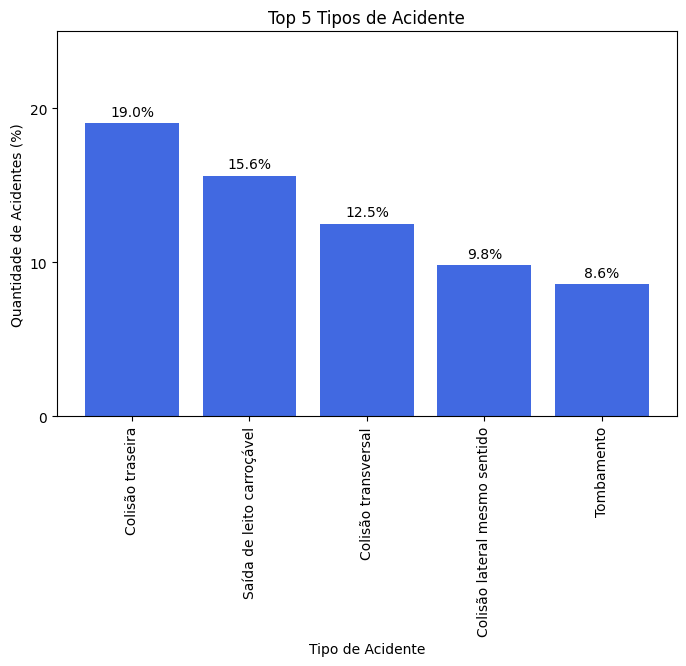

In [75]:
#contagem de acidentes por período do dia (%)
contagem = df['tipo_acidente'].value_counts(normalize=True).sort_index() * 100
contagem = contagem.sort_values(ascending=False)[:5]
fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(contagem.index, contagem.values, color='royalblue') #/contagem.sum() para %

valor_max = np.ceil(contagem.max()*1.1/5)*5 #arrendonda para cima para o próximo múltiplo de 5. O 1.1 é pra dar um respiro no gráfico.
ax.set_ylim(0, valor_max)

ticks = np.arange(0, valor_max+1, 10)
ax.set_yticks(ticks)

ax.bar_label(bars, fmt='%.1f%%', padding=3)

ax.set_title('Top 5 Tipos de Acidente')
ax.set_xlabel('Tipo de Acidente')
ax.set_ylabel('Quantidade de Acidentes (%)')

ax.set_xticklabels(contagem.index, rotation=90)


plt.show()

In [223]:
locais = {'Brasil': (-14.2350, -51.9253), 'Norte': (-3.4168, -65.8561), 'Nordeste': (-9.6620, -40.8200), 'Centro-Oeste': (-15.6000, -56.1000), 'Sudeste': (-20.3770, -43.4160), 'Sul': (-27.5000, -50.0000), 'AC': (-9.0238, -70.8120), 'AL': (-9.5713, -36.7820), 'AP': (1.4144, -51.7750), 'AM': (-3.4168, -65.8561), 'BA': (-12.5797, -41.7007), 'CE': (-5.4984, -39.3206), 'DF': (-15.7797, -47.9297), 'ES': (-19.1834, -40.3089), 'GO': (-15.8270, -49.8362), 'MA': (-5.4200, -45.0000), 'MT': (-12.6819, -56.9211), 'MS': (-20.7722, -54.7852), 'MG': (-18.5122, -44.5550), 'PA': (-3.4168, -52.3330), 'PB': (-7.2399, -36.7819), 'PR': (-24.8949, -51.5545), 'PE': (-8.8137, -36.9541), 'PI': (-7.7183, -42.7289), 'RJ': (-22.9068, -43.1729), 'RN': (-5.7945, -36.5261), 'RS': (-30.0346, -51.2177), 'RO': (-10.9430, -62.0686), 'RR': (2.7376, -62.0751), 'SC': (-27.2423, -50.2189), 'SP': (-23.5505, -46.6333), 'SE': (-10.5741, -37.3857), 'TO': (-10.1753, -48.2982)}

mapa = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)

estados = ['PR', 'RS', 'SC']

cores = {'Com Vítimas Feridas': '#FDFD96', 'Sem Vítimas': '#77DD77', 'Com Vítimas Fatais': '#FF6961'}

for _, row in df[df['uf'].isin(estados)][:5000].iterrows():

   

    folium.CircleMarker(
    location=[row['latitude'].replace(',','.'), row['longitude'].replace(',','.')],
    radius=1,            # raio em pixels
    color=cores[row['classificacao_acidente']],         # cor da borda
    # fill=True,           
    # fill_color=cores[row['classificacao_acidente']],    # cor do preenchimento
    fill_opacity=0.7,    
    popup='Acidente grave aqui!'
                        ).add_to(mapa)



mapa
